# Вторая задача

In [1]:
import requests
import pandas as pd 
import time
import os
os.chdir(r'C:\Users\Admin\Downloads\Telegram Desktop')
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

# Выгрузка данных 

In [2]:
def read(path: str):
    df = pd.read_csv(f'./{path}', sep=';').drop(columns=['dataset'])

    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    
    return df
    

In [3]:
rate = read("Официальный_курс_доллара_США_на_заданную_дату,_устанавливаемый_ежедневно.csv")
stavka = read("Базовая_ставка_краткосрочная,_%,_Россия_—_Диаграмма.csv")

In [4]:
df_list = []

for count in range(0, 10000, 100):
    URL_SBER = f'https://iss.moex.com/iss/history/engines/stock/markets/shares/securities/SBER.json?start={count}' 
    
    response_SBER = requests.get(URL_SBER)
    data_SBER = response_SBER.json()["history"]

    if response_SBER.status_code == 200:

        columns_SBER = data_SBER["columns"]
        values_SBER = data_SBER["data"]
        
        df_temp = pd.DataFrame(values_SBER, columns=columns_SBER)
        df_list.append(df_temp)
    else:
        print(f"Ошибка при получении данных: {response_SBER.status_code}")
        
df_SBER = pd.concat(df_list, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11696\2609164059.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_SBER = pd.concat(df_list, ignore_index=True)


In [5]:
df_list = []

for count in range(0, 7000, 100):
    URL_history = f'https://iss.moex.com/iss/history/engines/stock/markets/index/securities/IMOEX.json?start={count}' 
    
    response_history = requests.get(URL_history)
 
    if response_history.status_code == 200:
        data_history = response_history.json()["history"]

        columns_history = data_history["columns"]
        values_history = data_history["data"]
        
        df_temp = pd.DataFrame(values_history, columns=columns_history)
        df_list.append(df_temp)
    else:
        print(f"Ошибка при получении данных: {response_history.status_code}")


df_history = pd.concat(df_list, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11696\1946984765.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_history = pd.concat(df_list, ignore_index=True)


# Предобработка rate

In [6]:
rate

,date,"Официальный курс доллара США на заданную дату, устанавливаемый ежедневно."
0,1992-07-01,125.2600
1,1992-07-03,134.8000
2,1992-07-08,130.5000
3,1992-07-10,130.3000
4,1992-07-15,130.2000
...,...,...
7364,2024-06-22,87.9595
7365,2024-06-25,87.3730
7366,2024-06-26,87.2770
7367,2024-06-27,87.8064


In [7]:
rate_cleaned = (rate.drop_duplicates(subset=['date'])
                .dropna(subset=['Официальный курс доллара США на заданную дату, устанавливаемый ежедневно.'])
                .rename(columns={'Официальный курс доллара США на заданную дату, устанавливаемый ежедневно.': "Курс рубля"})
               )
rate_cleaned['Курс рубля в %'] = (rate_cleaned['Курс рубля'] - rate_cleaned['Курс рубля'].shift(12)) / rate_cleaned['Курс рубля'].shift(12)
rate_cleaned = (rate_cleaned.dropna()
                .reset_index(drop=True))
rate_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7357 entries, 0 to 7356
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            7357 non-null   datetime64[ns]
 1   Курс рубля      7357 non-null   float64       
 2   Курс рубля в %  7357 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 172.6 KB


In [8]:
rate_cleaned.head(3)

,date,Курс рубля,Курс рубля в %
0,1992-08-12,161.7,0.290915
1,1992-08-14,162.5,0.205490
2,1992-08-19,162.5,0.245211


# Предобработка stavka

In [9]:
stavka.head(3)

,date,"Базовая ставка - краткосрочная, %, Россия"
0,1992-01-31,20.0
1,1992-02-29,20.0
2,1992-03-31,20.0


In [10]:
stavka_cleaned = (stavka.set_index('date')
                  .resample('D')
                  .ffill()
                  .reset_index()
                 )
stavka_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 2 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   date                                       11749 non-null  datetime64[ns]
 1   Базовая ставка - краткосрочная, %, Россия  11749 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 183.7 KB


In [11]:
stavka_cleaned.head(3)

,date,"Базовая ставка - краткосрочная, %, Россия"
0,1992-01-31,20.0
1,1992-02-01,20.0
2,1992-02-02,20.0


# Предобработка SBER`а 

In [12]:
df_SBER.head(3)

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,...,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR
0,EQBR,2011-11-21,Сбербанк,SBER,128096,2.283014e+10,79.00,75.85,79.37,76.00,...,77.71,77.71,77.71,2.283016e+10,2.283016e+10,2.283016e+10,NaN,3,SUR,-5.05
1,SMAL,2011-11-21,Сбербанк,SBER,56,2.539949e+04,79.49,74.50,79.49,75.44,...,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,3,SUR,-7.45
2,EQBR,2011-11-22,Сбербанк,SBER,126144,2.091095e+10,76.40,75.10,77.76,76.08,...,76.71,76.71,76.71,2.091103e+10,2.091103e+10,2.091103e+10,NaN,3,SUR,0.54


In [13]:
df_SBER['TRADEDATE'] = pd.to_datetime(df_SBER['TRADEDATE'], format='%Y-%m-%d')
df_SBER_cleaned = (df_SBER.loc[:, ["TRADEDATE", "SHORTNAME", "OPEN"]]
                    .dropna(subset="OPEN")
                    .rename(columns={"TRADEDATE": "date", "SHORTNAME": "Название компании", "OPEN": "Цена компании"})
                  )
df_SBER_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6582 entries, 0 to 8841
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               6582 non-null   datetime64[ns]
 1   Название компании  6582 non-null   object        
 2   Цена компании      6582 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 205.7+ KB


In [14]:
df_SBER_cleaned.head(3)

,date,Название компании,Цена компании
0,2011-11-21,Сбербанк,79.00
1,2011-11-21,Сбербанк,79.49
2,2011-11-22,Сбербанк,76.40


# Предобработка мосбиржи

In [15]:
df_history.head(3)

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME
0,SNDX,IMOEX,1997-09-22,Индекс МосБиржи,Индекс МосБиржи,100.00,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,RUB,NaN,3,None
1,SNDX,IMOEX,1997-09-23,Индекс МосБиржи,Индекс МосБиржи,100.67,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,RUB,NaN,3,None
2,SNDX,IMOEX,1997-09-24,Индекс МосБиржи,Индекс МосБиржи,99.94,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,RUB,NaN,3,None


In [16]:
df_history['TRADEDATE'] = pd.to_datetime(df_history['TRADEDATE'], format='%Y-%m-%d')
df_history_cleaned = (df_history.loc[:, ["TRADEDATE", "SHORTNAME", "CLOSE"]]
                      .rename(columns={"TRADEDATE": "date", "SHORTNAME": "Название индекса", "CLOSE": "Цена индекса"})
                     )
df_history_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              6718 non-null   datetime64[ns]
 1   Название индекса  6718 non-null   object        
 2   Цена индекса      6718 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 157.6+ KB


In [17]:
df_history_cleaned.head(3)

,date,Название индекса,Цена индекса
0,1997-09-22,Индекс МосБиржи,100.00
1,1997-09-23,Индекс МосБиржи,100.67
2,1997-09-24,Индекс МосБиржи,99.94


# Объединяем все в один датафрейм

In [18]:
df = df_SBER_cleaned.merge(df_history_cleaned, on="date").merge(rate_cleaned, on="date").merge(stavka_cleaned, on="date")
df.head()

,date,Название компании,Цена компании,Название индекса,Цена индекса,Курс рубля,Курс рубля в %,"Базовая ставка - краткосрочная, %, Россия"
0,2011-11-22,Сбербанк,76.40,Индекс МосБиржи,1401.91,30.9693,0.009331,8.25
1,2011-11-22,Сбербанк,73.20,Индекс МосБиржи,1401.91,30.9693,0.009331,8.25
2,2011-11-23,Сбербанк,75.00,Индекс МосБиржи,1404.26,31.0612,0.007048,8.25
3,2011-11-23,Сбербанк,76.23,Индекс МосБиржи,1404.26,31.0612,0.007048,8.25
4,2011-11-24,Сбербанк,76.73,Индекс МосБиржи,1392.75,31.2133,0.021064,8.25


# Рассмотрим корреляцию


In [19]:
df.drop(columns=['date', 'Название компании', 'Название индекса']).corr()

,Цена компании,Цена индекса,Курс рубля,Курс рубля в %,"Базовая ставка - краткосрочная, %, Россия"
Цена компании,1.000000,0.942273,0.704353,-0.068820,-0.244837
Цена индекса,0.942273,1.000000,0.777092,-0.095461,-0.166111
Курс рубля,0.704353,0.777092,1.000000,0.012760,0.202285
Курс рубля в %,-0.068820,-0.095461,0.012760,1.000000,-0.207488
"Базовая ставка - краткосрочная, %, Россия",-0.244837,-0.166111,0.202285,-0.207488,1.000000


# Нормализуем данные


In [20]:
X = df[['Цена индекса', "Курс рубля"]]
y = df[['Цена компании']]

In [21]:
x_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)

X_scaled = x_scaler.transform(X)
y_scaled = y_scaler.transform(y)

# Создаем тренировочный и тестовый датафрейм

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.1)

# Создаем модель

In [23]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

# Смотрим качество модели 

In [24]:
predict = model.predict(x_train)

mean_absolute_percentage_error(y_true=y_train, y_pred=predict)

92752906788.37515

In [25]:
test_predict = model.predict(x_test)

mean_absolute_percentage_error(y_true=y_test, y_pred=test_predict)

0.12889841401758967

In [26]:
predict = model.predict(x_train)

mean_squared_error(y_true=y_train, y_pred=predict, squared=False)

0.07633318562996722

In [27]:
test_predict = model.predict(x_test)

mean_squared_error(y_true=y_test, y_pred=test_predict, squared=False)

0.08244434286833538

# Визуализируем 

In [28]:
train_range = range(x_train.shape[0])
test_range = range(train_range[-1], train_range[-1] + x_test.shape[0])

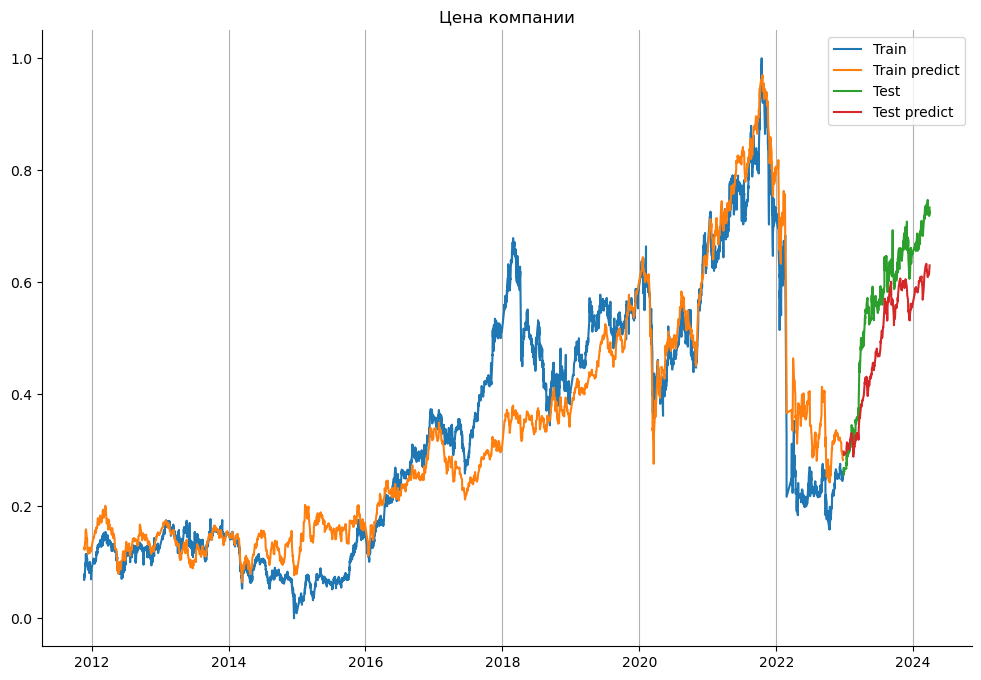

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title('Цена компании')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(df.date[:len(y_train)], y_train, label='Train')
ax.plot(df.date[:len(predict)], predict, label='Train predict')

ax.plot(df.date[len(y_train):len(y_train) + len(y_test)], y_test, label='Test')
ax.plot(df.date[len(y_train):len(y_train) + len(test_predict)], test_predict, label='Test predict')

ax.grid(axis='x')
ax.legend()

# Проверка весов факторов 

In [30]:
w_0 = model.intercept_[0] 
w_1 = model.coef_[0][0]   # Цена индекса
w_2 = model.coef_[0][1]   # Курс рубля

print(f'Коэффициенты линейной регрессии:\n{w_0 = }\n{w_1 = }\n{w_2 = }')

Коэффициенты линейной регрессии:
w_0 = 0.07719101949711743
w_1 = 0.9661197397104897
w_2 = -0.12965973846887938


In [31]:
# Курс рубля почти не влияет на предсказание модели, убрав его метрики улучшатся, а график почти не изменится 
# Специально не выкладываю проверку весов, так как решение довольно громоздкое

# Проверка значимости коэффициентов корреляции

In [32]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           3.83e-62
Time:                        09:08:17   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [34]:
# я не очень понял, за что отвечают x1:x10, но x1, x5, x6, x7, x8, x10 случайны